## Behavioral Cloning - P3 

Some visualizations to take a look at the data before training

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc
import pandas as pd
import collections
%matplotlib inline
import math
import csv
import cv2
import os.path

print('Modules Imported!!')

Modules Imported!!


In [19]:
# Load Data:

print('Reading from data folder the driving log.')
columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

file_path = './data/driving_log.csv'
driving_data = pd.read_csv(file_path, names=columns)[1:]

print('Columns : ', columns)
print('Data Loaded!!')

Reading from data folder the driving log.
Columns :  ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
Data Loaded!!


In [20]:
# Visualize Data
driving_data.iloc[:10]

,center,left,right,steering,throttle,brake,speed
1,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0,0,0,22.14829
2,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0,0,0,21.87963
3,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0,0,0,1.453011
4,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0,0,0,1.438419
5,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0,0,0,1.418236
6,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0,0,0,1.403993
7,IMG/center_2016_12_01_13_31_13_381.jpg,IMG/left_2016_12_01_13_31_13_381.jpg,IMG/right_2016_12_01_13_31_13_381.jpg,0,0,0,1.389892
8,IMG/center_2016_12_01_13_31_13_482.jpg,IMG/left_2016_12_01_13_31_13_482.jpg,IMG/right_2016_12_01_13_31_13_482.jpg,0,0,0,1.375934
9,IMG/center_2016_12_01_13_31_13_584.jpg,IMG/left_2016_12_01_13_31_13_584.jpg,IMG/right_2016_12_01_13_31_13_584.jpg,0,0,0,1.362115
10,IMG/center_2016_12_01_13_31_13_686.jpg,IMG/left_2016_12_01_13_31_13_686.jpg,IMG/right_2016_12_01_13_31_13_686.jpg,0,0,0,1.348435


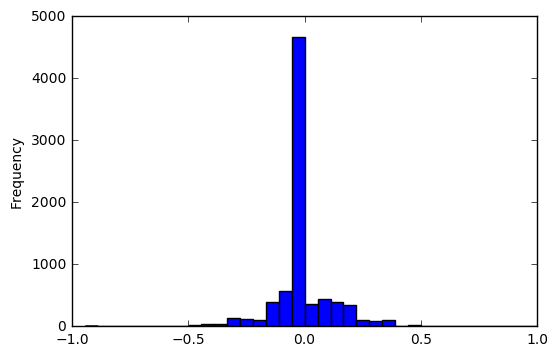

In [23]:
# Visualize Steering data .. there seems to be a lot of zeros .. Thanks to Vivek, Annie Flippo, and Nick Hortovanyi for 
# showing me ideas on to visualize this part ..

driving_data['steering']=driving_data['steering'].astype(float)
driving_data['steering'].plot.hist(bins=35)

In [24]:
# In Nick's blog post, he also used some explanation tools to get more information about the data:
driving_data['steering'].describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

It seems from the description and diagram above that our data is somehow learning towards a right biased , am tempted to say
almost normal distriction. However it seems that we have some negative steering values. Not sure what that means? /

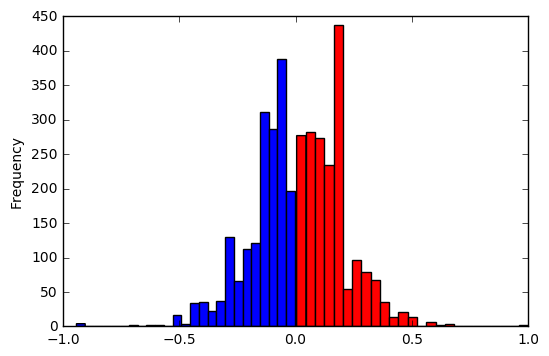

In [30]:
# from nicks work too, it seems pandas lets us query the values .. pretty cool !!!
driving_data.query('steering > 0')['steering'].plot.hist(bins=25, color='red')

driving_data.query('steering < 0')['steering'].plot.hist(bins=25, color='blue')

So considerable amount of data with negative steering. Now lets get some data on the speed shall we:

In [33]:
driving_data['speed']=driving_data['speed'].astype(float)
driving_data['speed'].describe()

count    8036.000000
mean       28.169839
std         6.149327
min         0.502490
25%        30.183093
50%        30.186400
75%        30.186640
max        30.709360
Name: speed, dtype: float64

Seems we had an average speed of 28 miles per hour (assuming those are the units).

(33, 100, 3)

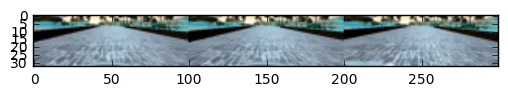

In [83]:
# Now lets visualize images and see what can we do with them

right_image = mpimg.imread('./data/'+driving_data['right'][1].strip())
right_image_copy = np.copy(right_image)
right_image = cv2.cvtColor(right_image_copy, cv2.COLOR_BGR2RGB)

center_image = mpimg.imread('./data/'+driving_data['center'][1].strip())
center_image_copy = np.copy(center_image)
center_image = cv2.cvtColor(center_image_copy, cv2.COLOR_BGR2RGB)


left_image = mpimg.imread('./data/'+driving_data['center'][1].strip())
left_image_copy = np.copy(left_image)
left_image = cv2.cvtColor(left_image_copy, cv2.COLOR_BGR2RGB)

pad=np.zeros((160,10,3), np.uint8)

plt.imshow(np.hstack((left_image, pad, center_image, pad, right_image)))

# Now inspired by Vivek , and Annie, lets try and crop the image to get rid of where the car is
left_image = left_image[math.floor(left_image.shape[0]/4):left_image.shape[0]-13, 0:left_image.shape[1]]
ratio = 100.0 / left_image.shape[1]
dim = (100, int(left_image.shape[0] * ratio))
left_image = cv2.resize(left_image, dim, interpolation=cv2.INTER_AREA)

center_image = center_image[math.floor(center_image.shape[0]/4):center_image.shape[0]-13, 0:center_image.shape[1]]
ratio = 100.0 / center_image.shape[1]
dim = (100, int(center_image.shape[0] * ratio))
center_image = cv2.resize(center_image, dim, interpolation=cv2.INTER_AREA)

right_image = right_image[math.floor(right_image.shape[0]/4):right_image.shape[0]-13, 0:right_image.shape[1]]
ratio = 100.0 / right_image.shape[1]
dim = (100, int(right_image.shape[0] * ratio))
right_image = cv2.resize(right_image, dim, interpolation=cv2.INTER_AREA)

plt.imshow(np.hstack((left_image, center_image, right_image)))

center_image.shape